In [1]:
import os
os.chdir("/home/jupyter/Natasha2")# for GCP use
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'
from torchvision.models.resnet import ResNet, BasicBlock,resnet152
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from numpy import *
import inspect
import time
import torch
from torch import nn, optim
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Lambda
from torch.utils.data import DataLoader
from Natasha1 import Natasha1
from Natasha2 import Natasha2
from utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# MNIST

In [2]:
from train import train_val_Mnist

learning curves have the following information:  
train_loss  
validation_loss  
precision  
recall  
F1  
accuracy  

In [3]:
learning_curves_Natasha1_lenet = train_val_Mnist(algorithm='Natasha1', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using CPU...
[train.py] using optimization algorithm Natasha1
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.2554618295576018, validation loss: 2.0995755195617676
	     precision: 0.1738
	        recall: 0.3105
	            F1: 0.2031
	      accuracy: 0.3165



Epoch 2/10, training loss: 0.1569693268362139, validation loss: 1.1341170072555542
	     precision: 0.5610
	        recall: 0.5874
	            F1: 0.5296
	      accuracy: 0.5993



Epoch 3/10, training loss: 0.10105672256270451, validation loss: 0.8250057697296143
	     precision: 0.7206
	        recall: 0.7153
	            F1: 0.6902
	      accuracy: 0.7268



Epoch 4/10, training loss: 0.0980314557740429, validation loss: 0.7742725610733032
	     precision: 0.7530
	        recall: 0.7309
	            F1: 0.7100
	      accuracy: 0.7404



Epoch 5/10, training loss: 0.09742271582455014, validation loss: 0.800938069820404
	     precision: 0.7212
	        recall: 0.7224
	            F1: 0.6900
	      accuracy: 0.7280



Epoch 6/10, training loss: 0.08441622561610329, validation loss: 0.6488794684410095
	     precision: 0.7876
	        recall: 0.7795
	            F1: 0.7638
	      accuracy: 0.7888



Epoch 7/10, training loss: 0.06580302071596768, validation loss: 0.7071591019630432
	     precision: 0.7689
	        recall: 0.7404
	            F1: 0.7136
	      accuracy: 0.7496



Epoch 8/10, training loss: 0.06937012495770892, validation loss: 0.5543056130409241
	     precision: 0.8248
	        recall: 0.8190
	            F1: 0.8054
	      accuracy: 0.8262



Epoch 9/10, training loss: 0.06322265058946508, validation loss: 0.5489279627799988
	     precision: 0.8232
	        recall: 0.8163
	            F1: 0.8005
	      accuracy: 0.8230



Epoch 10/10, training loss: 0.05842276197125409, validation loss: 0.675460696220398
	     precision: 0.7918
	        recall: 0.7663
	            F1: 0.7421
	      accuracy: 0.7705
Training time: 101.45186638832092s


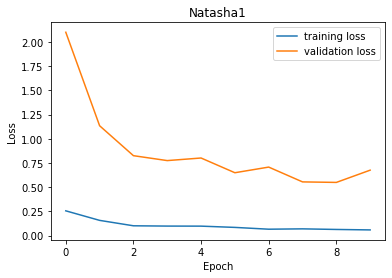

In [4]:
train_loss_Natasha1_lenet = learning_curves_Natasha1_lenet['train_loss']
ax = plt.axes()
ax.set_title("Natasha1")
ax.plot(learning_curves_Natasha1_lenet['train_loss'], label='training loss')
ax.plot(learning_curves_Natasha1_lenet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [5]:
learning_curves_Adam_lenet = train_val_Mnist(algorithm='Adam', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using CPU...
[train.py] using optimization algorithm Adam
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.2129639834483295, validation loss: 2.00944185256958
	     precision: 0.1441
	        recall: 0.2469
	            F1: 0.1456
	      accuracy: 0.2437



Epoch 2/10, training loss: 0.158412731024248, validation loss: 1.4632283449172974
	     precision: 0.4492
	        recall: 0.4689
	            F1: 0.4089
	      accuracy: 0.4640



Epoch 3/10, training loss: 0.11757393730983043, validation loss: 1.055981993675232
	     precision: 0.5761
	        recall: 0.6059
	            F1: 0.5574
	      accuracy: 0.5980



Epoch 4/10, training loss: 0.09622594548949301, validation loss: 0.8727625012397766
	     precision: 0.6890
	        recall: 0.6854
	            F1: 0.6484
	      accuracy: 0.6789



Epoch 5/10, training loss: 0.09049870737834272, validation loss: 0.7283739447593689
	     precision: 0.7808
	        recall: 0.7721
	            F1: 0.7565
	      accuracy: 0.7725



Epoch 6/10, training loss: 0.06861299457453461, validation loss: 0.6665273308753967
	     precision: 0.7994
	        recall: 0.7917
	            F1: 0.7769
	      accuracy: 0.7942



Epoch 7/10, training loss: 0.07334555857090046, validation loss: 0.594352662563324
	     precision: 0.8244
	        recall: 0.8172
	            F1: 0.8032
	      accuracy: 0.8196



Epoch 8/10, training loss: 0.05037000216146522, validation loss: 0.5533832907676697
	     precision: 0.8372
	        recall: 0.8285
	            F1: 0.8179
	      accuracy: 0.8315



Epoch 9/10, training loss: 0.057500804093346666, validation loss: 0.5214271545410156
	     precision: 0.8476
	        recall: 0.8398
	            F1: 0.8283
	      accuracy: 0.8422



Epoch 10/10, training loss: 0.05307975468605058, validation loss: 0.5118580460548401
	     precision: 0.8519
	        recall: 0.8424
	            F1: 0.8329
	      accuracy: 0.8456
Training time: 91.60966038703918s


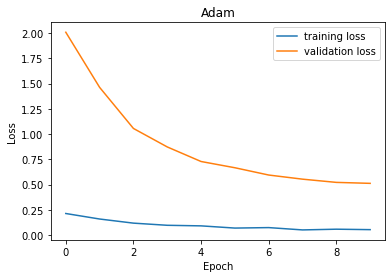

In [7]:
train_loss_Adam_lenet = learning_curves_Adam_lenet['train_loss']
ax = plt.axes()
ax.set_title("Adam")
ax.plot(learning_curves_Adam_lenet['train_loss'], label='training loss')
ax.plot(learning_curves_Adam_lenet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [8]:
learning_curves_SGD_lenet = train_val_Mnist(algorithm='SGD', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using CPU...
[train.py] using optimization algorithm SGD
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.24445792225632332, validation loss: 2.3414461612701416
	     precision: 0.0194
	        recall: 0.0990
	            F1: 0.0269
	      accuracy: 0.1007



Epoch 2/10, training loss: 0.2634204641334029, validation loss: 2.331982374191284
	     precision: 0.0133
	        recall: 0.0988
	            F1: 0.0195
	      accuracy: 0.0997



Epoch 3/10, training loss: 0.21571749029383222, validation loss: 2.3249757289886475
	     precision: 0.0121
	        recall: 0.0999
	            F1: 0.0187
	      accuracy: 0.1009



Epoch 4/10, training loss: 0.2126184523995243, validation loss: 2.3174567222595215
	     precision: 0.0192
	        recall: 0.1009
	            F1: 0.0287
	      accuracy: 0.1023



Epoch 5/10, training loss: 0.2367341632782015, validation loss: 2.3094193935394287
	     precision: 0.0194
	        recall: 0.1023
	            F1: 0.0250
	      accuracy: 0.1034



Epoch 6/10, training loss: 0.2186030830655779, validation loss: 2.3017945289611816
	     precision: 0.0225
	        recall: 0.1040
	            F1: 0.0298
	      accuracy: 0.1052



Epoch 7/10, training loss: 0.22507832197746488, validation loss: 2.2930641174316406
	     precision: 0.0376
	        recall: 0.1049
	            F1: 0.0328
	      accuracy: 0.1058



Epoch 8/10, training loss: 0.2190506898009701, validation loss: 2.2824723720550537
	     precision: 0.0626
	        recall: 0.1354
	            F1: 0.0735
	      accuracy: 0.1345



Epoch 9/10, training loss: 0.20390981067218253, validation loss: 2.2680230140686035
	     precision: 0.0632
	        recall: 0.1480
	            F1: 0.0756
	      accuracy: 0.1459



Epoch 10/10, training loss: 0.2166863174072461, validation loss: 2.246701240539551
	     precision: 0.0815
	        recall: 0.1668
	            F1: 0.0944
	      accuracy: 0.1664
Training time: 91.07439613342285s


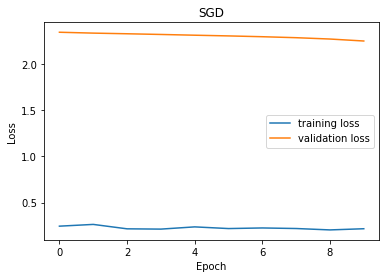

In [9]:
train_loss_SGD_lenet = learning_curves_SGD_lenet['train_loss']
ax = plt.axes()
ax.set_title("SGD")
ax.plot(learning_curves_SGD_lenet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_lenet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [10]:
learning_curves_SGD_momentum_lenet = train_val_Mnist(algorithm='SGD_momentum', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using CPU...
[train.py] using optimization algorithm SGD_momentum
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.21835674215227302, validation loss: 1.5893807411193848
	     precision: 0.3446
	        recall: 0.4541
	            F1: 0.3386
	      accuracy: 0.4547



Epoch 2/10, training loss: 0.09483405366254005, validation loss: 0.5978454351425171
	     precision: 0.8182
	        recall: 0.8095
	            F1: 0.7948
	      accuracy: 0.8117



Epoch 3/10, training loss: 0.043317680896472324, validation loss: 0.47377243638038635
	     precision: 0.8570
	        recall: 0.8517
	            F1: 0.8389
	      accuracy: 0.8543



Epoch 4/10, training loss: 0.052063906338931654, validation loss: 0.3891288638114929
	     precision: 0.8864
	        recall: 0.8794
	            F1: 0.8695
	      accuracy: 0.8842



Epoch 5/10, training loss: 0.042317839446606664, validation loss: 0.3384437561035156
	     precision: 0.9017
	        recall: 0.8919
	            F1: 0.8851
	      accuracy: 0.8952



Epoch 6/10, training loss: 0.039778623817317775, validation loss: 0.2958102226257324
	     precision: 0.9150
	        recall: 0.9113
	            F1: 0.9030
	      accuracy: 0.9114



Epoch 7/10, training loss: 0.03337354838911658, validation loss: 0.27918899059295654
	     precision: 0.9172
	        recall: 0.9145
	            F1: 0.9070
	      accuracy: 0.9155



Epoch 8/10, training loss: 0.02943638413509072, validation loss: 0.23874002695083618
	     precision: 0.9327
	        recall: 0.9318
	            F1: 0.9247
	      accuracy: 0.9308



Epoch 9/10, training loss: 0.022734160139870795, validation loss: 0.2391125112771988
	     precision: 0.9286
	        recall: 0.9263
	            F1: 0.9193
	      accuracy: 0.9247



Epoch 10/10, training loss: 0.029627518533770717, validation loss: 0.23322492837905884
	     precision: 0.9325
	        recall: 0.9322
	            F1: 0.9253
	      accuracy: 0.9321
Training time: 90.8452377319336s


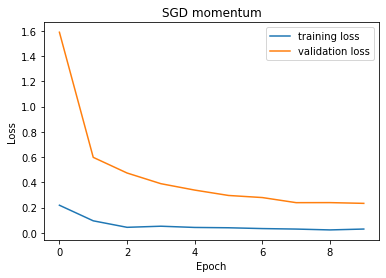

In [11]:
train_loss_SGD_momentum_lenet = learning_curves_SGD_momentum_lenet['train_loss']
ax = plt.axes()
ax.set_title("SGD momentum")
ax.plot(learning_curves_SGD_momentum_lenet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_momentum_lenet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

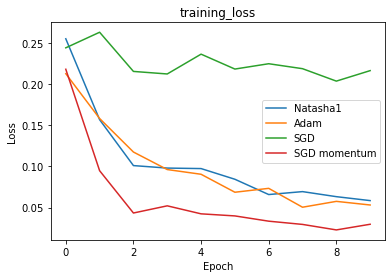

In [12]:
ax = plt.axes()
ax.set_title("training_loss")
ax.plot(learning_curves_Natasha1_lenet['train_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_lenet['train_loss'], label='Adam')
ax.plot(learning_curves_SGD_lenet['train_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_lenet['train_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

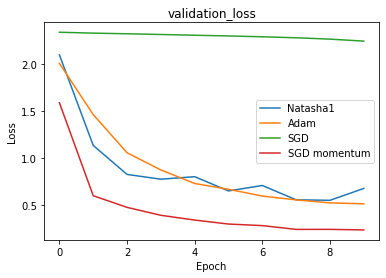

In [14]:
ax = plt.axes()
ax.set_title("validation_loss")
ax.plot(learning_curves_Natasha1_lenet['validation_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_lenet['validation_loss'], label='Adam')
ax.plot(learning_curves_SGD_lenet['validation_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_lenet['validation_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

# Linear model for debugging

In [ ]:
import numpy as np
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

In [ ]:
import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 10

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [ ]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
optimizer = Natasha2(model.parameters(), alpha=learningRate)

In [ ]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward(retain_graph=True)
    
    hessian_matrix = eval_hessian(loss, model)
    # update parameters
    optimizer.step(hessian_matrix)

    print('epoch {}, loss {}'.format(epoch, loss.item()))